In [21]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Import relevant scikit-learn modules
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV, train_test_split

%matplotlib inline

In [32]:
def fit_models(X_train, 
               X_test,
               y_train, 
               y_test,
               models=[]):
    predictions = []
    training_data = []
    r2_values = []
    rmse_values = []
    for model in models:
        print(model)
        # fit the model and generate predictions
        model.fit(X_train, y_train.ravel())
       
        preds = model.predict(X_test)
        t_dat = model.predict(X_train)

        # calculate an R-squared and RMSE values
        r_squared = r2_score(y_test, preds)
        rmse = mean_squared_error(y_test, preds) ** 0.5

        # append all to lists
        predictions.append(preds)
        training_data.append(t_dat)
        r2_values.append(r_squared)
        rmse_values.append(rmse)
    print('Done fitting models')
    return predictions, training_data, r2_values, rmse_values

def plot_models(predictions, training_data,
                r2_values,
                rmse_values,
                y_test, y_train,
                titles =['Linear Regression',
                          'k-Nearest Neighbors',
                          'Support Vector Machine',
                          'Neural Network [5 neurons]',
                          'Neural Network [100 neurons]',
                          'Random Forest'],
                positions=[231,232,233,234,235,236],
                save=False):

    fig = plt.figure(figsize=(15,10))
    for pos, pred, train, r2, rmse, title in zip(positions,
                                          predictions,
                                          training_data,
                                          r2_values,
                                          rmse_values,
                                          titles):
        # create subplot
        plt.subplot(pos)
        plt.grid(alpha=0.2)
        plt.title(title, fontsize=15)
        
        # add score patches
        r2_patch = mpatches.Patch(label="R2 = {:04.2f}".format(r2), color='green')
        rmse_patch = mpatches.Patch(label="RMSE = {:3.1f}".format(rmse), color='green')
        plt.xlim(-10,2)
        plt.ylim(-10,2)
        plt.scatter(pred, y_test, alpha=0.2, color='green')
        plt.scatter(train, y_train, alpha=0.1, )
        plt.legend(handles=[r2_patch, rmse_patch], fontsize=12)
        plt.plot(np.arange(5), np.arange(5), ls="--", c=".3")
        fig.text(0.5, 0.08, 'predicted values', ha='center', va='center', fontsize=15)
        fig.text(0.09, 0.5, 'observed values', ha='center', va='center', rotation='vertical', fontsize=15)
    if save:
        plt.savefig(save, dpi = 300)
    plt.show()

In [33]:
models = [LinearRegression(),
          KNeighborsRegressor(n_neighbors=7), # use k = 7 as in papers
          LinearSVR(),
          MLPRegressor(hidden_layer_sizes=(5), # 5-neurons are used in the initial
                       activation='logistic',  # release of the paper
                       solver='sgd',
                       max_iter=10000,
                       random_state=42),
          MLPRegressor(hidden_layer_sizes=(100),
                       activation='logistic',
                       solver='sgd',
                       max_iter=10000,
                       random_state=42),
          RandomForestRegressor(n_estimators=500, # 500 trees
                                random_state=42)
         ]

In [34]:
# START HERE !
# Define path and csv files
DATA_DIR = './'
INPUTS = 'solubility_data.csv'

In [35]:
# Load the raw chemical features as input
data = pd.read_csv(DATA_DIR + INPUTS)
data.head()


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [36]:
# values to predict
Y = data['measured log solubility in mols per litre']

# features (remove non-numeric data, the y-values, and in this example a previously predicted y-value)
X = data.drop(['ESOL predicted log solubility in mols per litre','measured log solubility in mols per litre'], axis=1)._get_numeric_data()

X.head()

,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area
0,1,457.432,7,3,7,202.32
1,1,201.225,1,2,2,42.24
2,1,152.237,0,0,4,17.07
3,2,278.354,0,5,0,0.00
4,2,84.143,0,1,0,0.00


In [37]:
# Split into train/test sub-samples (TT_SPLIT = 0.2 means 80/20 train/test)
TT_SPLIT = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=TT_SPLIT, random_state=42)

In [38]:
# Now scale the data based on the training sample
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

LinearRegression()
KNeighborsRegressor(n_neighbors=7)
LinearSVR()
MLPRegressor(activation='logistic', hidden_layer_sizes=5, max_iter=10000,
             random_state=42, solver='sgd')
MLPRegressor(activation='logistic', hidden_layer_sizes=100, max_iter=10000,
             random_state=42, solver='sgd')
RandomForestRegressor(n_estimators=500, random_state=42)
Done fitting models


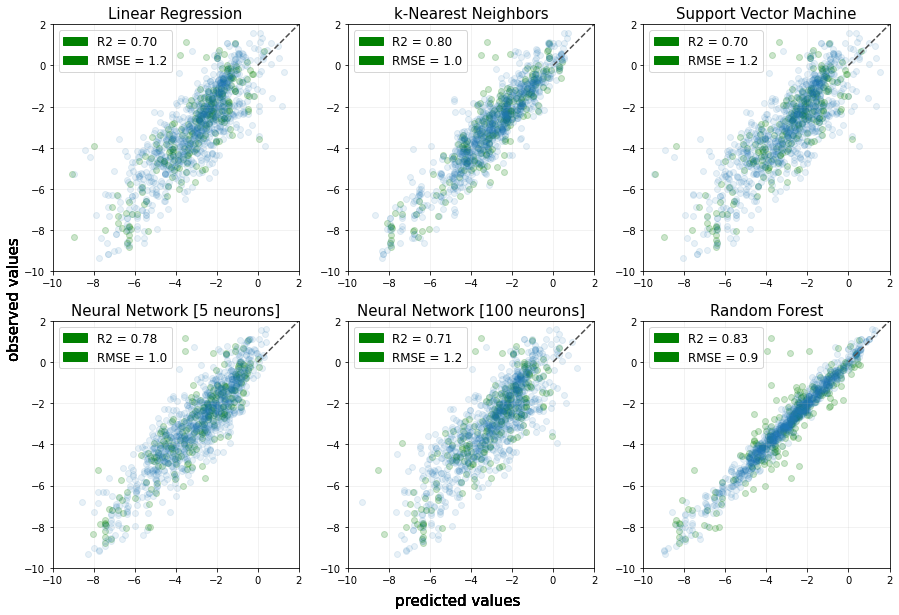

In [39]:
# Run the regression models and plot
# note that there is no hyperparameter tuning being done here, so in theory it is possible to improve
# performance of the non-linear models

preds, training_data, r2_values, rmse_values  = fit_models(X_train, X_test, y_train, y_test, models)
plot_models(preds, training_data, r2_values, rmse_values, y_test, y_train)

LinearRegression()
KNeighborsRegressor(n_neighbors=7)
LinearSVR()
MLPRegressor(activation='logistic', hidden_layer_sizes=5, max_iter=10000,
             random_state=42, solver='sgd')
MLPRegressor(activation='logistic', hidden_layer_sizes=100, max_iter=10000,
             random_state=42, solver='sgd')


/Users/rpaton/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RandomForestRegressor(n_estimators=500, random_state=42)
Done fitting models


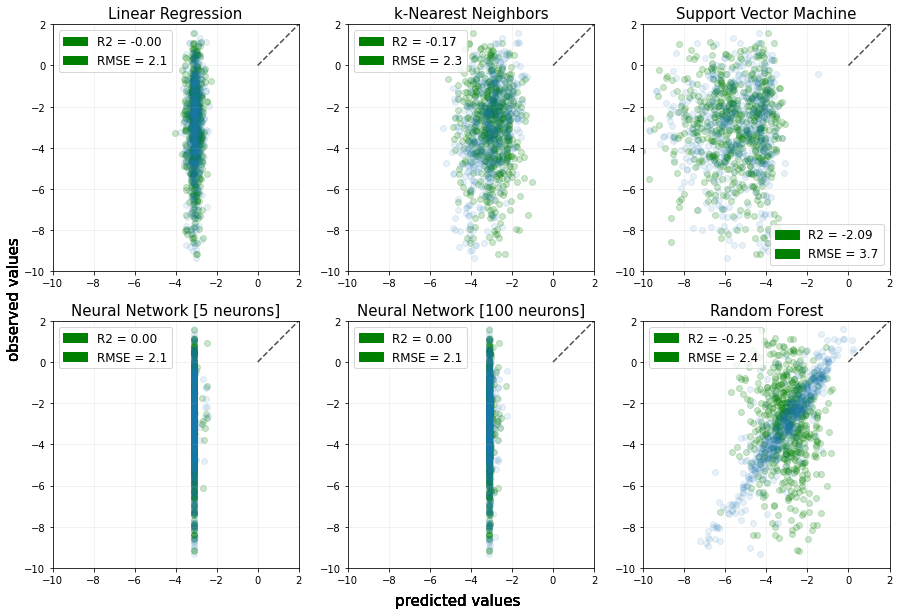

In [40]:
# Simple model validation (necessary but not sufficient to show that we have a robust model)
# Now compare against shuffled y values
# This should break the correlation - if high correlation remains, then the model is non-sensical

y_shuf = np.random.permutation(Y)

X_train, X_test, y_train, y_test = train_test_split(X, y_shuf, test_size=0.5, random_state=42)
preds, training_data, r2_values, rmse_values  = fit_models(X_train, X_test, y_train, y_test, models)
plot_models(preds, training_data, r2_values, rmse_values, y_test, y_train)

LinearRegression()
KNeighborsRegressor(n_neighbors=7)
LinearSVR()
MLPRegressor(activation='logistic', hidden_layer_sizes=5, max_iter=10000,
             random_state=42, solver='sgd')
MLPRegressor(activation='logistic', hidden_layer_sizes=100, max_iter=10000,
             random_state=42, solver='sgd')
RandomForestRegressor(n_estimators=500, random_state=42)
Done fitting models


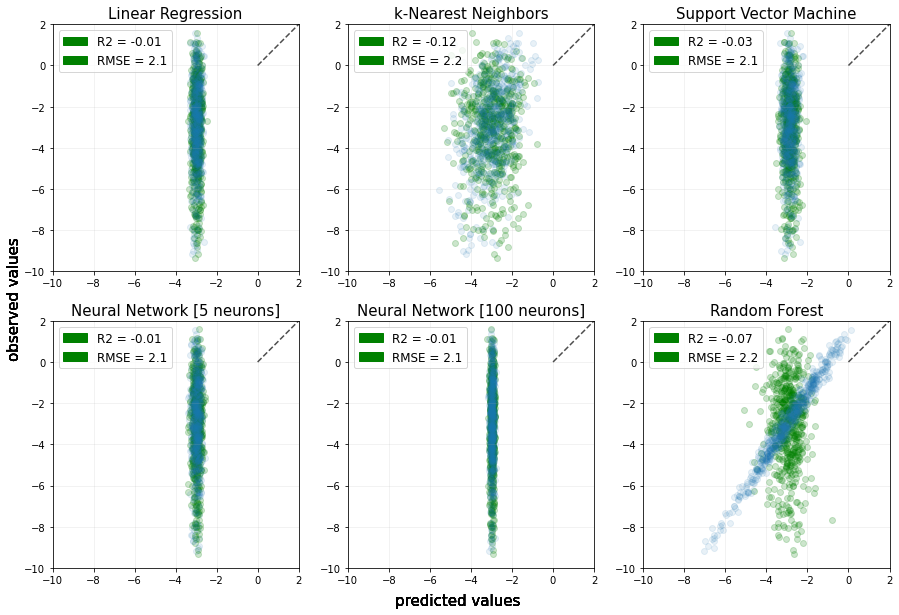

In [41]:
# now compare against random'barcodes' as feature vectors
# This should break the correlation - if high correlation remains, then the model is non-sensical

X = np.random.randn(X.shape[0], X.shape[1])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=42)
preds, training_data, r2_values, rmse_values  = fit_models(X_train, X_test, y_train, y_test, models)
plot_models(preds, training_data, r2_values, rmse_values, y_test, y_train)